In [876]:
import torch
import torchvision
import torch.nn as nn
from torchvision import tv_tensors
# from torchvision import datapoints
from torchvision.transforms import v2
from torch.nn import functional as F
from torchvision.transforms.v2.functional import to_pil_image

import json
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [877]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [878]:
import sys
sys.path.append("drive/MyDrive/SSD/")

from feature_extractor import SSDFeatureExtractor

In [879]:
def plot_images(images, bboxes=None, labels=None, class_names=None, figsize=(10, 10)):
    # Generated by ChatGPT.

    # Ensure images is a list for batch processing
    if isinstance(images, torch.Tensor):
        images = [images] if images.dim() == 3 else list(images)

    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, (img, ax) in enumerate(zip(images, axes)):
        # Convert tensor to numpy and move to range [0, 1]
        img = to_pil_image(img)  # Convert (C, H, W) to PIL
        ax.imshow(img)

        # Draw bounding boxes if provided
        if bboxes is not None and bboxes[i] is not None:
            for j, box in enumerate(bboxes[i]):
                x_min, y_min, x_max, y_max = map(float, box)
                width, height = x_max - x_min, y_max - y_min

                # Create a rectangle
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='b', facecolor='none')
                ax.add_patch(rect)

                # Add label text if provided
                if labels is not None and class_names is not None:
                    label_idx = int(labels[i][j])  # Convert tensor to integer index
                    ax.text(x_min, y_min - 5, class_names[label_idx], color='white',
                            bbox=dict(facecolor='blue', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

        ax.axis("off")  # Hide axes

    plt.show()

In [880]:
path = Path("drive/MyDrive/Datasets/pascal-voc-2012/VOC2012/")

In [881]:
with open(path/'data.json', 'r') as file:
    data = json.load(file)

In [882]:
all_classes = list(set(cls for d in data for cls in d["class"]))
all_classes.insert(0, "bg")

In [883]:
labels_to_index = {y:x for x, y in list(enumerate(all_classes))}
labels_to_index

{'bg': 0,
 'pottedplant': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'sofa': 5,
 'train': 6,
 'cow': 7,
 'horse': 8,
 'bus': 9,
 'diningtable': 10,
 'bottle': 11,
 'tvmonitor': 12,
 'chair': 13,
 'person': 14,
 'cat': 15,
 'sheep': 16,
 'dog': 17,
 'motorbike': 18,
 'car': 19,
 'aeroplane': 20}

In [884]:
index_to_labels = {v:k for k, v in labels_to_index.items()}
index_to_labels

{0: 'bg',
 1: 'pottedplant',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'sofa',
 6: 'train',
 7: 'cow',
 8: 'horse',
 9: 'bus',
 10: 'diningtable',
 11: 'bottle',
 12: 'tvmonitor',
 13: 'chair',
 14: 'person',
 15: 'cat',
 16: 'sheep',
 17: 'dog',
 18: 'motorbike',
 19: 'car',
 20: 'aeroplane'}

In [885]:
d = data[17049]
d

{'filename': '2007_000727.jpg',
 'class': ['bus', 'car', 'car', 'person', 'person', 'person', 'car', 'car'],
 'bbox': [['89', '323', '273', '436'],
  ['272', '369', '323', '388'],
  ['2', '380', '89', '435'],
  ['333', '356', '358', '438'],
  ['319', '357', '341', '424'],
  ['354', '363', '375', '414'],
  ['49', '367', '90', '389'],
  ['113', '138', '160', '164']]}

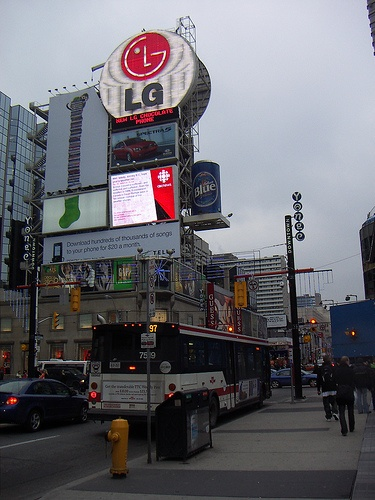

In [886]:
img = Image.open(path/"JPEGImages"/d["filename"]).convert("RGB")
img

In [887]:
img_t = v2.ToTensor()(img).unsqueeze(0)
img_t.shape

torch.Size([1, 3, 500, 375])

In [888]:
x_transforms = v2.Compose((
    v2.RandomResizedCrop((300, 300)),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    )
)

In [889]:
img_t2 = x_transforms(img_t)

In [890]:
def bbox_to_tensor(bboxes, format, img_size=0):
    return tv_tensors.BoundingBoxes([list(map(float, bbox)) for bbox in bboxes], format=format, canvas_size=img_size)

In [891]:
bbox_t = bbox_to_tensor(d["bbox"], "XYXY", img.size[::-1])
bbox_t

BoundingBoxes([[ 89., 323., 273., 436.],
               [272., 369., 323., 388.],
               [  2., 380.,  89., 435.],
               [333., 356., 358., 438.],
               [319., 357., 341., 424.],
               [354., 363., 375., 414.],
               [ 49., 367.,  90., 389.],
               [113., 138., 160., 164.]], format=BoundingBoxFormat.XYXY, canvas_size=(500, 375))

In [892]:
# ToDo: Change the parsing funtion to return float values of bboxes.

In [893]:
labels = d["class"]
labels

['bus', 'car', 'car', 'person', 'person', 'person', 'car', 'car']

In [894]:
labels_t = torch.tensor([labels_to_index[k] for k in labels])
labels_t

tensor([ 9, 19, 19, 14, 14, 14, 19, 19])

In [895]:
img_t2, bbox_t2, labels_t2 = x_transforms(img_t, bbox_t, labels_t)
labels_t2

tensor([ 9, 19, 19, 14, 14, 14, 19, 19])

In [896]:
bbox_t2.shape

torch.Size([8, 4])

In [897]:
torch.cat([img_t2]*2).shape

torch.Size([2, 3, 300, 300])

In [898]:
([img_t2]*2)[0].shape

torch.Size([1, 3, 300, 300])

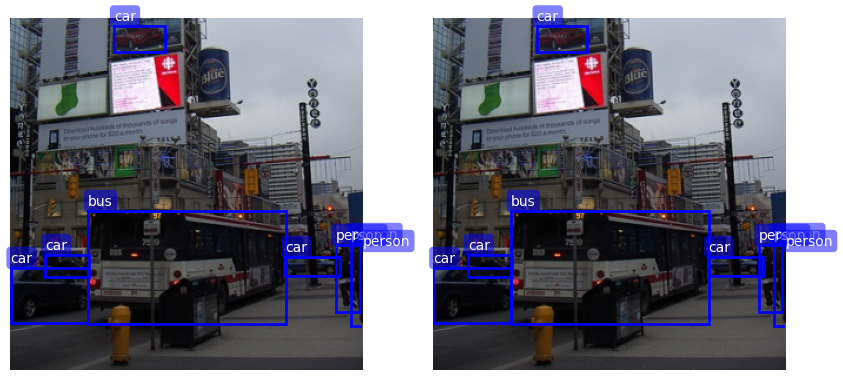

In [899]:
plot_images(torch.cat([img_t2]*2), torch.stack([bbox_t2]*2), torch.stack([labels_t2]*2), list(all_classes))

In [900]:
torch.stack([bbox_t2]*2).shape

torch.Size([2, 8, 4])

In [901]:
ext = SSDFeatureExtractor()

In [902]:
maps = ext(img_t2)

In [903]:
for k, v in maps.items():
    print(k, v.shape)

conv4_3 torch.Size([1, 512, 38, 38])
conv7 torch.Size([1, 1024, 19, 19])
conv8_2 torch.Size([1, 512, 10, 10])
conv9_2 torch.Size([1, 256, 5, 5])
conv10_2 torch.Size([1, 256, 3, 3])
conv11_2 torch.Size([1, 256, 1, 1])


In [904]:
n_maps = 6
n_dbox_per_map = torch.tensor([4, 6, 6, 6, 4, 4])
aspect_ratios = torch.tensor([1, 2, 1/2, 1/3, 3])
feature_map_sizes = torch.tensor([38, 19, 10, 5, 3, 1])
s_max, s_min = torch.tensor(0.9), torch.tensor(0.1)

In [905]:
feature_map_sizes*feature_map_sizes*n_dbox_per_map

tensor([5776, 2166,  600,  150,   36,    4])

In [906]:
def _calculate_scale(k, n_maps, s_min=0.2, s_max=0.9):
        f = lambda k: (s_min + ((s_max-s_min)/(n_maps-1))*(k-1))

        s1 = torch.tensor(0.1 if k==1 else f(k))
        s2 = torch.sqrt(s1*f(k+1))

        return s1, torch.min(s2, torch.tensor(s_max))

In [907]:
k = 1

In [908]:
s1 = s_min+((s_max-s_min)/(n_maps-1))*(k-1)
s1

tensor(0.1000)

In [909]:
s1 = 0.1

In [910]:
(s_min+((s_max-s_min)/(n_maps-1))*(k+1-1))

tensor(0.2600)

In [911]:
scales = [_calculate_scale(k, n_maps) for k in range(1, n_maps+1)]

In [912]:
scales

[(tensor(0.1000), tensor(0.1844)),
 (tensor(0.3400), tensor(0.4040)),
 (tensor(0.4800), tensor(0.5455)),
 (tensor(0.6200), tensor(0.6864)),
 (tensor(0.7600), tensor(0.8270)),
 (tensor(0.9000), tensor(0.9000))]

In [913]:
ll = []
for s in scales:
    for ar in aspect_ratios[:-2]:
        ll.append((s[0]/torch.sqrt(ar), s[0]*torch.sqrt(ar)))

In [914]:
aspect_ratios[:-2]

tensor([1.0000, 2.0000, 0.5000])

In [915]:
torch.tensor(ll).max(dim=0)

torch.return_types.max(
values=tensor([1.2728, 1.2728]),
indices=tensor([17, 16]))

In [916]:
def _create_default_boxes(self, maps, n_dbox, scales, aspect_ratios):
        pass

In [917]:
# Example feature map implementation
k = 1
size = 38
n_dbox = 4

In [918]:
# Default Box Generator:
# 1. Calculate scales
# 2. Calculate center
# 3. Calculate height and width

# For a size 38 map with 4 dboxes per pixel, expected shape is (38*38*4, 4)

In [919]:
scale = _calculate_scale(4, n_maps)
scale

(tensor(0.6200), tensor(0.6864))

In [920]:
def _create_default_boxes(feature_map_sizes, n_dbox_per_map, scales, aspect_ratios):
    dboxes_per_map = []
    for size, n_dbox, scale in zip(feature_map_sizes, n_dbox_per_map, scales):
        dboxes = []
        for i in range(size):
            for j in range(size):
                center_x = (i+0.5)/size
                center_y = (j+0.5)/size

                for ratio in aspect_ratios[:n_dbox-1]:
                    height = scale[0]/torch.sqrt(ratio)
                    width = scale[0]*torch.sqrt(ratio)
                    dboxes.append([center_x, center_y, width, height])

                # Extra box for ascpect ratio 1
                height = scale[1]
                width = scale[1]
                dboxes.append([center_x, center_y, width, height])
        dboxes_per_map.append(torch.tensor(dboxes))

    return dboxes_per_map

In [921]:
dboxes_per_map = _create_default_boxes(feature_map_sizes, n_dbox_per_map, scales, aspect_ratios)

In [922]:
sq = torch.sqrt(torch.tensor(0.3333))
sq

tensor(0.5773)

In [923]:
scale[0]/sq

tensor(1.0739)

In [924]:
for dboxes in dboxes_per_map:
    print(dboxes.shape)

torch.Size([5776, 4])
torch.Size([2166, 4])
torch.Size([600, 4])
torch.Size([150, 4])
torch.Size([36, 4])
torch.Size([4, 4])


In [925]:
for dboxes in dboxes_per_map:
    print(torch.max(dboxes, dim=0))

torch.return_types.max(
values=tensor([0.9868, 0.9868, 0.1844, 0.1844]),
indices=tensor([5624,  148,    3,    3]))
torch.return_types.max(
values=tensor([0.9737, 0.9737, 0.5889, 0.5889]),
indices=tensor([2052,  108,    4,    3]))
torch.return_types.max(
values=tensor([0.9500, 0.9500, 0.8314, 0.8314]),
indices=tensor([540,  54,   4,   3]))
torch.return_types.max(
values=tensor([0.9000, 0.9000, 1.0739, 1.0739]),
indices=tensor([120,  24,   4,   3]))
torch.return_types.max(
values=tensor([0.8333, 0.8333, 1.0748, 1.0748]),
indices=tensor([24,  8,  1,  2]))
torch.return_types.max(
values=tensor([0.5000, 0.5000, 1.2728, 1.2728]),
indices=tensor([0, 0, 1, 2]))


In [926]:
len(dboxes_per_map)

6

In [927]:
def transform_bbox_to_xyxy(bbox, img_size=300, denorm=False):
    cx, cy, w, h = bbox
    bbox_ = torch.tensor([cx-w/2, cy-h/2, cx+w/2, cy+h/2])
    return bbox_*(img_size) if denorm else bbox_

In [928]:
def transform_bbox_to_chw(bbox, img_size=300, norm=False):
    x_min, y_min, x_max, y_max = bbox
    center_x, center_y = (x_min+x_max)/2, (y_min+y_max)/2
    width, height = x_max-x_min, y_max-y_min
    bbox_ = torch.tensor([center_x, center_y, height, width])
    return bbox_/(img_size) if norm else bbox_

In [929]:
transform_bbox_to_chw([10, 10, 100, 100], norm=False)

tensor([55., 55., 90., 90.])

In [930]:
transform_bbox_to_xyxy(dboxes_per_map[0][0], denorm=True)

tensor([-11.0526, -11.0526,  18.9474,  18.9474])

In [931]:
transform_bbox_to_xyxy(dboxes_per_map[0][5], denorm=False)

tensor([-0.0576,  0.0041,  0.0839,  0.0748])

In [932]:
dboxes_per_map[0][3]*300

tensor([ 3.9474,  3.9474, 55.3173, 55.3173])

In [933]:
for ratio in [1, 2, 1/2]:
    sq = torch.sqrt(torch.tensor(ratio))
    print(0.1/sq, 0.1*sq)

tensor(0.1000) tensor(0.1000)
tensor(0.0707) tensor(0.1414)
tensor(0.1414) tensor(0.0707)


In [934]:
cx, cy = ((0+0.5)/38), ((1+0.5)/38)

In [935]:
transform_bbox_to_xyxy([cx, cy, 0.1, 0.1], denorm=1)

tensor([-11.0526,  -3.1579,  18.9474,  26.8421])

In [936]:
dboxes_per_map[0][0]

tensor([0.0132, 0.0132, 0.1000, 0.1000])

In [937]:
vdb = [transform_bbox_to_xyxy(bbox, denorm=True) for bbox in dboxes_per_map[0][::47]]
len(vdb)

123

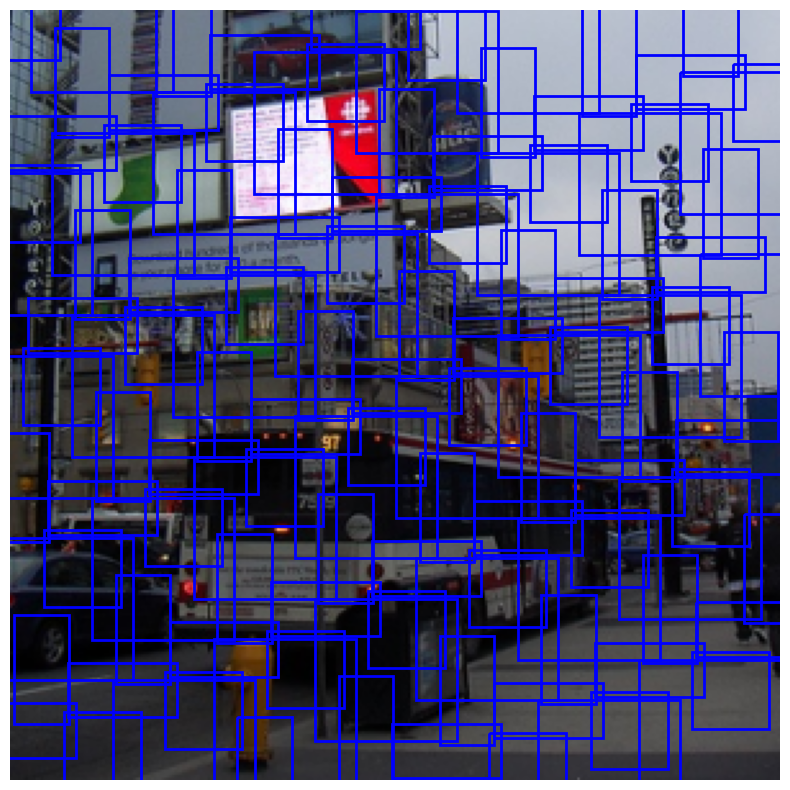

In [938]:
plot_images(img_t2, [vdb])

In [939]:
class DefaultBoxGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.n_maps = 6
        self.register_buffer("n_dbox_per_map", torch.tensor([4, 6, 6, 6, 4, 4]))
        self.register_buffer("aspect_ratios", torch.tensor([1, 2, 1/2, 1/3, 3]))
        self.register_buffer("feature_map_sizes", torch.tensor([38, 19, 10, 5, 3, 1]))

        scales = [self._calculate_scale(k, self.n_maps,) for k in range(1, self.n_maps+1)]
        self.register_buffer("scales", torch.tensor(scales))
        dboxes_per_map = self._create_default_boxes(self.feature_map_sizes,
                                                 self.n_dbox_per_map,
                                                 self.scales, self.aspect_ratios)
        self.register_buffer("dboxes", torch.cat(dboxes_per_map))


    def _create_default_boxes(self, feature_map_sizes, n_dbox_per_map, scales, aspect_ratios):
        a = []
        b = []
        count = 0
        dboxes_per_map = []
        for size, n_dbox, scale in zip(feature_map_sizes, n_dbox_per_map, scales):
            dboxes = []
            for i in range(size):
                for j in range(size):
                    center_x = (i+0.5)/size
                    center_y = (j+0.5)/size
                    # print(center_y)

                    for ratio in aspect_ratios[:n_dbox-1]:
                        height = scale[0]/torch.sqrt(ratio)
                        width = scale[0]*torch.sqrt(ratio)
                        dboxes.append([center_x, center_y, width, height])

                    # Extra box for ascpect ratio 1
                    height = scale[1]
                    width = scale[1]
                    dboxes.append([center_x, center_y, width, height])
                    b.append(center_y.item())
                a.append(center_x.item())
                count += 1
            dboxes_per_map.append(torch.tensor(dboxes))

        return dboxes_per_map


    def _calculate_scale(self, k, n_maps, s_min=0.2, s_max=0.9):
        # k is the nth feature map
        f = lambda k: (s_min + ((s_max-s_min)/(n_maps-1))*(k-1))

        s1 = torch.tensor(0.1 if k==1 else f(k))
        s2 = torch.sqrt(s1*f(k+1))

        return s1, torch.min(s2, torch.tensor(s_max))

In [940]:
db_gen = DefaultBoxGenerator()

In [941]:
feature_map_sizes**2*n_dbox_per_map

tensor([5776, 2166,  600,  150,   36,    4])

In [942]:
ss = torch.tensor([9,28,47,59,64,73])

In [943]:
(ss[0]+0.5)/38, (ss[1]+0.5)/38

(tensor(0.2500), tensor(0.7500))

In [944]:
(ss[2]-38+0.5)/19, (ss[3]-57+0.5)/10, (ss[4]-57+0.5)/10, (ss[5]-67+0.5)/5

(tensor(0.5000), tensor(0.2500), tensor(0.7500), tensor(1.3000))

In [945]:
torch.cat([dbox for dbox in db_gen.dboxes]).shape

torch.Size([34928])

In [946]:
db_gen.dboxes.dtype

torch.float32

In [947]:
db_gen.scales.dtype

torch.float32

In [948]:
def jaccard(bbox1, bbox2):
    # Boxes are assumed in xyxy format
    w1, h1 = bbox1[2]-bbox1[0], bbox1[3]-bbox1[1]
    w2, h2 = bbox2[2]-bbox2[0], bbox2[3]-bbox2[1]

    inter_xmin = torch.max(bbox1[0], bbox2[0])
    inter_ymin = torch.max(bbox1[1], bbox2[1])
    inter_xmax = torch.min(bbox1[2], bbox2[2])
    inter_ymax = torch.min(bbox1[3], bbox2[3])


    inter_w = torch.clamp(inter_xmax-inter_xmin, min=0)
    inter_h = torch.clamp(inter_ymax-inter_ymin, min=0)

    intersection = inter_h*inter_w
    union = h1*w1 + h2*w2 - intersection

    return intersection/union

In [949]:
jaccard(torch.tensor([10, 10, 20, 20]), torch.tensor([15, 15, 25, 25]))

tensor(0.1429)

In [950]:
b = torch.tensor(list(map(int, d["bbox"][0])))/300
b

tensor([0.2967, 1.0767, 0.9100, 1.4533])

In [951]:
dbb = db_gen.dboxes[3000:3008]
dbb

tensor([[0.5132, 0.7500, 0.1000, 0.1000],
        [0.5132, 0.7500, 0.1414, 0.0707],
        [0.5132, 0.7500, 0.0707, 0.1414],
        [0.5132, 0.7500, 0.1844, 0.1844],
        [0.5132, 0.7763, 0.1000, 0.1000],
        [0.5132, 0.7763, 0.1414, 0.0707],
        [0.5132, 0.7763, 0.0707, 0.1414],
        [0.5132, 0.7763, 0.1844, 0.1844]])

In [952]:
cx, cy, h, w = [dbb[:, i] for i in range(4)]

In [953]:
cx, cy, h, w = dbb.T

In [954]:
bbox_ = [cx-w/2, cy-h/2, cx+w/2, cy+h/2]
res = torch.stack(bbox_, dim=1)
res

tensor([[0.4632, 0.7000, 0.5632, 0.8000],
        [0.4778, 0.6793, 0.5485, 0.8207],
        [0.4424, 0.7146, 0.5839, 0.7854],
        [0.4210, 0.6578, 0.6054, 0.8422],
        [0.4632, 0.7263, 0.5632, 0.8263],
        [0.4778, 0.7056, 0.5485, 0.8470],
        [0.4424, 0.7410, 0.5839, 0.8117],
        [0.4210, 0.6841, 0.6054, 0.8685]])

In [955]:
bbox_[0].shape, res.shape

(torch.Size([8]), torch.Size([8, 4]))

In [956]:
def transform_cwh_to_xyxy(bboxes, image_size=300, denorm=False):
    """This functin expects a 2D input, even if one bbox to be transformed."""
    cx, cy, w, h = bboxes.T
    xyxy = torch.stack([cx-w/2, cy-h/2, cx+w/2, cy+h/2], dim=1)
    return xyxy*(image_size) if denorm else xyxy

In [957]:
transform_cwh_to_xyxy(dboxes_per_map[0], denorm=True).shape

torch.Size([5776, 4])

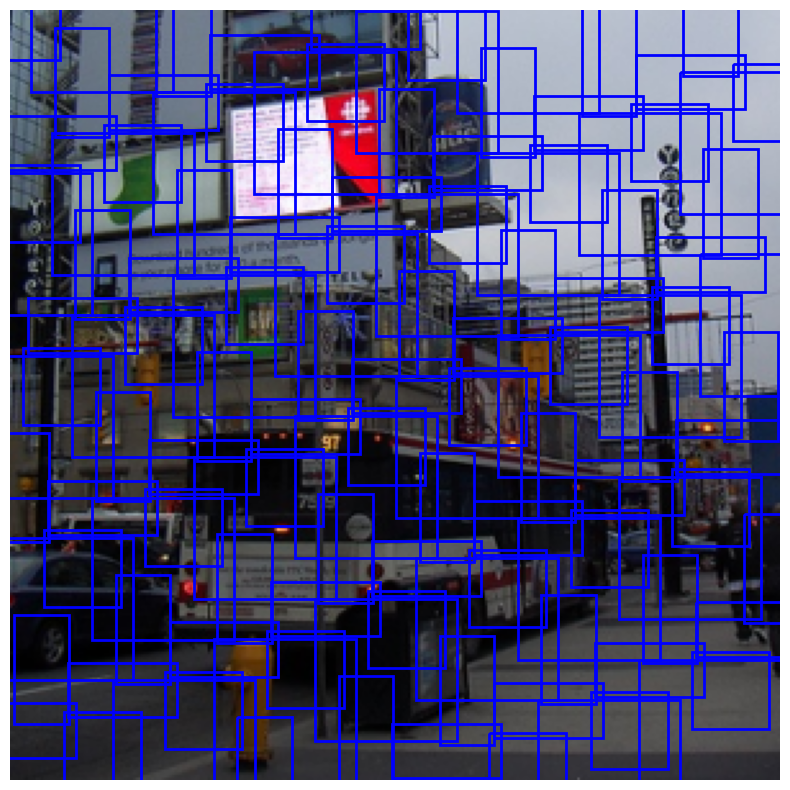

In [958]:
plot_images(img_t2, [transform_cwh_to_xyxy(dboxes_per_map[0][::47], denorm=True)])

In [959]:
dboxes_xyxy = transform_cwh_to_xyxy(db_gen.dboxes, denorm=False)
dboxes_xyxy.shape

torch.Size([8732, 4])

In [960]:
x, y = torch.max(b[:2], db_gen.dboxes[:, :2]), torch.min(b[2:], db_gen.dboxes[:, 2:])
x.shape, y.shape

(torch.Size([8732, 2]), torch.Size([8732, 2]))

In [961]:
z = torch.clamp(y-x, min=0)
z

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.4100, 0.0000],
        [0.1364, 0.1961],
        [0.4000, 0.0000]])

In [962]:
intersections = z[:,0]*z[:,1]
intersections.shape

torch.Size([8732])

In [963]:
h1, w1 = b[3]-b[1], b[2]-b[0]
h1, w1

(tensor(0.3767), tensor(0.6133))

In [964]:
h2, w2 = dboxes_xyxy[:, 3] - dboxes_xyxy[:, 1], dboxes_xyxy[:, 2] - dboxes_xyxy[:, 0]
h2.shape, w2.shape

(torch.Size([8732]), torch.Size([8732]))

In [965]:
unions = h1*w1+h2*w2-intersections

In [966]:
ious = intersections/unions

In [967]:
torch.max(ious)

tensor(0.0264)

In [968]:
b*299

tensor([ 88.7033, 321.9233, 272.0900, 434.5467])

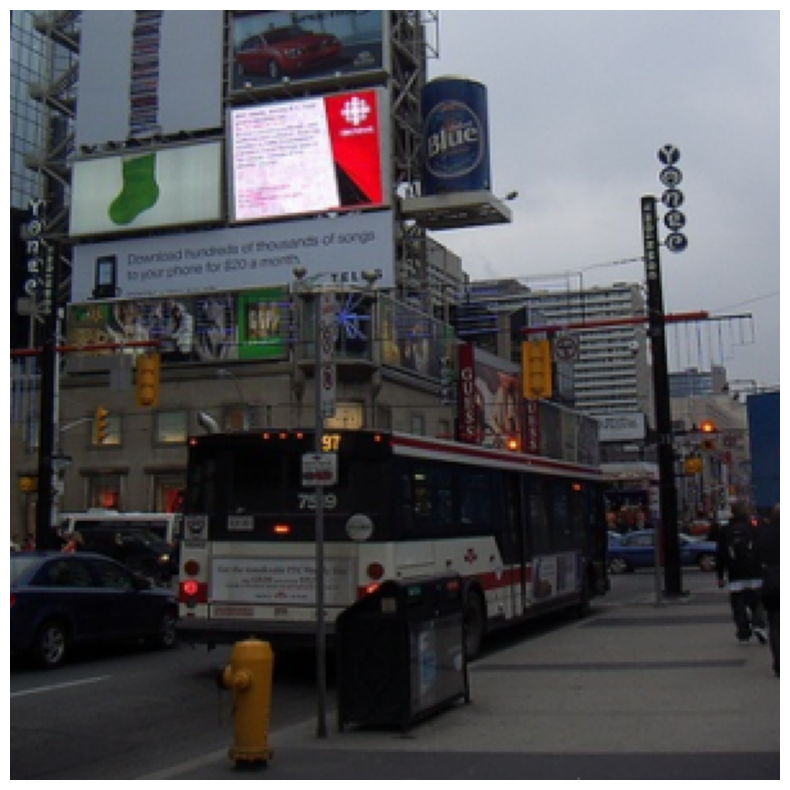

In [969]:
plot_images(img_t2, [[b*299]])

In [970]:
# What's next:
# 1. Load data in pytorch to perform batch operations
# 2. Transform bboxes
# 3. Complete DefaultBoxGenerator class by creating ground truth generator function.
# 4. Create better jaccard function. -
# 5. Create better bbox transformation functions. -

#Take 2 at jaccard

In [971]:
def jaccard(bbox1, bbox2):
    # Boxes are assumed in xyxy format
    w1, h1 = bbox1[2]-bbox1[0], bbox1[3]-bbox1[1]
    w2, h2 = bbox2[2]-bbox2[0], bbox2[3]-bbox2[1]

    inter_xmin = torch.max(bbox1[0], bbox2[0])
    inter_ymin = torch.max(bbox1[1], bbox2[1])
    inter_xmax = torch.min(bbox1[2], bbox2[2])
    inter_ymax = torch.min(bbox1[3], bbox2[3])


    inter_w = torch.clamp(inter_xmax-inter_xmin, min=0)
    inter_h = torch.clamp(inter_ymax-inter_ymin, min=0)

    intersection = inter_h*inter_w
    union = h1*w1 + h2*w2 - intersection

    return intersection/union

In [972]:
# 1. Transform default boxes to XYXY format.
# 2. Calculate jaccard
# 3. Selection:
#       Default box with max overlap
#       Default boxes with overlap > 0.5


In [973]:
# Raw ground truth
img_t2.shape, bbox_t2.shape, labels_t2.shape

(torch.Size([1, 3, 300, 300]), torch.Size([8, 4]), torch.Size([8]))

In [974]:
dboxes_xyxy.shape

torch.Size([8732, 4])

In [975]:
# Matching one box with all dboxes

In [976]:
bbox_t2[0]

tensor([ 66.0550, 164.0227, 234.8624, 260.0566])

In [977]:
w1 = bbox_t2[:, 2] - bbox_t2[:, 0]
h1 = bbox_t2[:, 3] - bbox_t2[:, 1]
w1.shape, h1.shape

(torch.Size([8]), torch.Size([8]))

In [978]:
w2 = dboxes_xyxy[:, 2] - dboxes_xyxy[:, 0]
h2 = dboxes_xyxy[:, 3] - dboxes_xyxy[:, 1]
w2.shape, h2.shape

(torch.Size([8732]), torch.Size([8732]))

In [979]:
bbox_t2[:, 0]

tensor([ 66.0550, 233.9449,   0.0000, 289.9083, 277.0642, 300.0000,  29.3578,
         88.0734])

In [980]:
bbox_t2

BoundingBoxes([[ 66.0550, 164.0227, 234.8624, 260.0566],
               [233.9449, 203.1161, 280.7339, 219.2635],
               [  0.0000, 212.4646,  66.0550, 259.2068],
               [289.9083, 192.0680, 300.0000, 261.7564],
               [277.0642, 192.9178, 297.2477, 249.8584],
               [300.0000, 198.0170, 300.0000, 241.3598],
               [ 29.3578, 201.4164,  66.9725, 220.1133],
               [ 88.0734,   6.7989, 131.1927,  28.8952]], format=BoundingBoxFormat.XYXY, canvas_size=(300, 300))

In [981]:
x_min1, y_min1, x_max1, y_max1 = bbox_t2.T[:, None]

In [982]:
bbox_t2.T[:, None].shape, x_min1.shape

(torch.Size([4, 1, 8]), torch.Size([1, 8]))

In [983]:
x_min2, y_min2, x_max2, y_max2 = dboxes_xyxy.T

In [984]:
ar1 = ((x_max1 - x_min1)*(y_max1-y_min1)).T
ar1.shape

torch.Size([8, 1])

In [985]:
ar2 = (x_max2 - x_min2)*(y_max2-y_min2)
ar2.shape

torch.Size([8732])

In [986]:
(ar1+ar2).shape

torch.Size([8, 8732])

In [987]:
x_min2.shape

torch.Size([8732])

In [988]:
torch.max(bbox_t2[:, None, 0], x_min2).shape

torch.Size([8, 8732])

In [989]:
bbox_t2[:, None, 0].shape

torch.Size([8, 1])

In [990]:
torch.max(x_min1.T, x_min2*300)[:, 4000]

tensor([194.2105, 233.9449, 194.2105, 289.9083, 277.0642, 300.0000, 194.2105,
        194.2105])

In [991]:
def jaccard_dboxes(bboxes, dboxes):
    """
    Function is made to find jaccard between all default boxes and bboxes in an image.
    Denormalized boxes in xyxy format are expected.
    jaccard_dboxes((N, 4), (8732, 4)) -> (N, 8732)"""
    xmin1, ymin1, xmax1, ymax1 = (bboxes[:, 0].unsqueeze(1),
                                  bboxes[:, 1].unsqueeze(1),
                                  bboxes[:, 2].unsqueeze(1),
                                  bboxes[:, 3].unsqueeze(1))
    xmin2, ymin2, xmax2, ymax2 = dboxes.T

    inter_xmin = torch.max(xmin1, xmin2)
    inter_ymin = torch.max(ymin1, ymin2)
    inter_xmax = torch.min(xmax1, xmax2)
    inter_ymax = torch.min(ymax1, ymax2)

    inter_w = torch.clamp(inter_xmax-inter_xmin, min=0)
    inter_h = torch.clamp(inter_ymax-inter_ymin, min=0)

    intersection = inter_w*inter_h
    union = (xmax1-xmin1)*(ymax1-ymin1) + (xmax2-xmin2)*(ymax2-ymin2) -intersection

    return intersection/union

In [992]:
xmin2, ymin2, xmax2, ymax2 = dboxes_xyxy.T
xmin1 = bbox_t2[:, 0].unsqueeze(1)
ymin1 = bbox_t2[:, 1].unsqueeze(1)
xmax1 = bbox_t2[:, 2].unsqueeze(1)
ymax1 = bbox_t2[:, 3].unsqueeze(1)
torch.max(xmin1, xmin2.unsqueeze(0)).shape, xmin1.shape, xmin2.unsqueeze(0).shape

(torch.Size([8, 8732]), torch.Size([8, 1]), torch.Size([1, 8732]))

In [ ]:
jaccard_dboxes()

In [993]:
j = jaccard_dboxes(bbox_t2, dboxes_xyxy*300)
j.shape

torch.Size([8, 8732])

In [994]:
c1 = torch.max(j, dim=1)
c1

torch.return_types.max(
values=tensor([0.6468, 0.7059, 0.7259, 0.3644, 0.6886, 0.0000, 0.7336, 0.7352]),
indices=tensor([8285, 4969,  727, 5734, 5582,    0, 1017, 1985]))

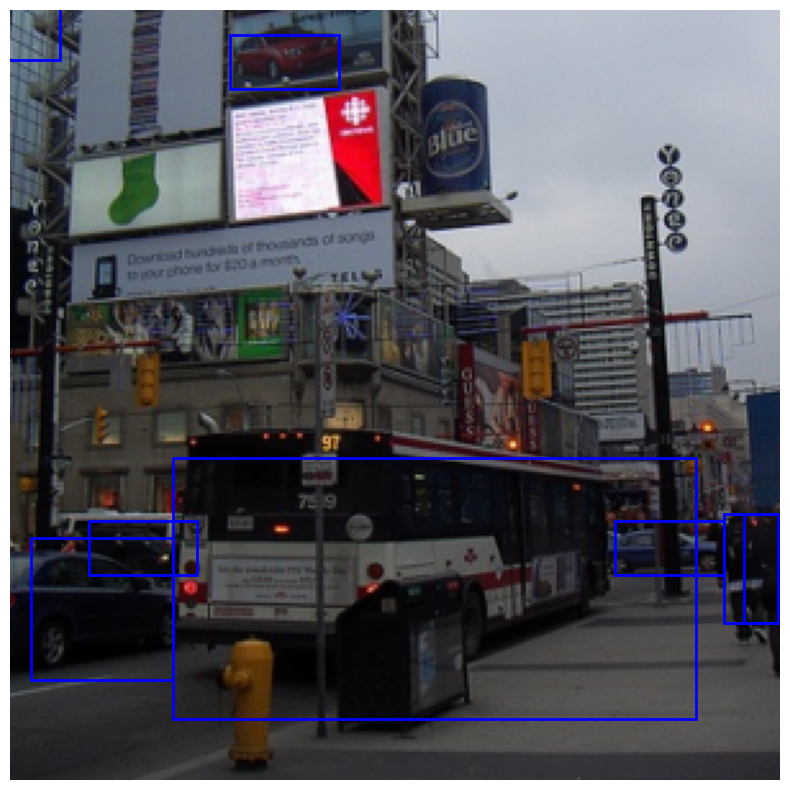

In [995]:
plot_images(img_t2, [dboxes_xyxy[c1[1]]*300])

In [996]:
(j>0.5)[0].shape

torch.Size([8732])

In [997]:
len(j)

8

In [998]:
c2 = torch.cat([dboxes_xyxy[(j>0.5)[i]] for i in range(len(j))])

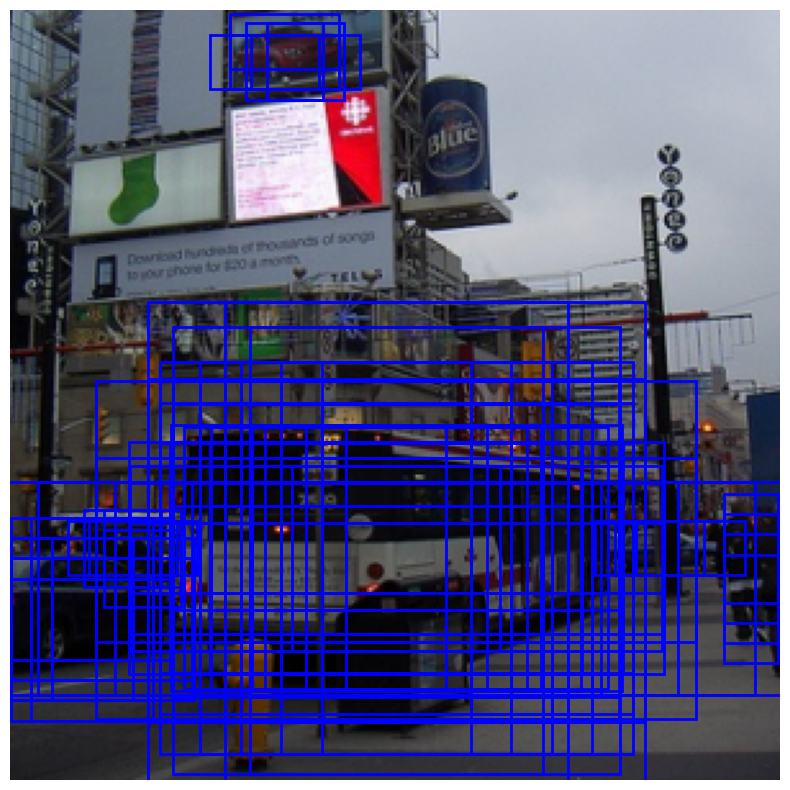

In [999]:
plot_images(img_t2, [c2*300])

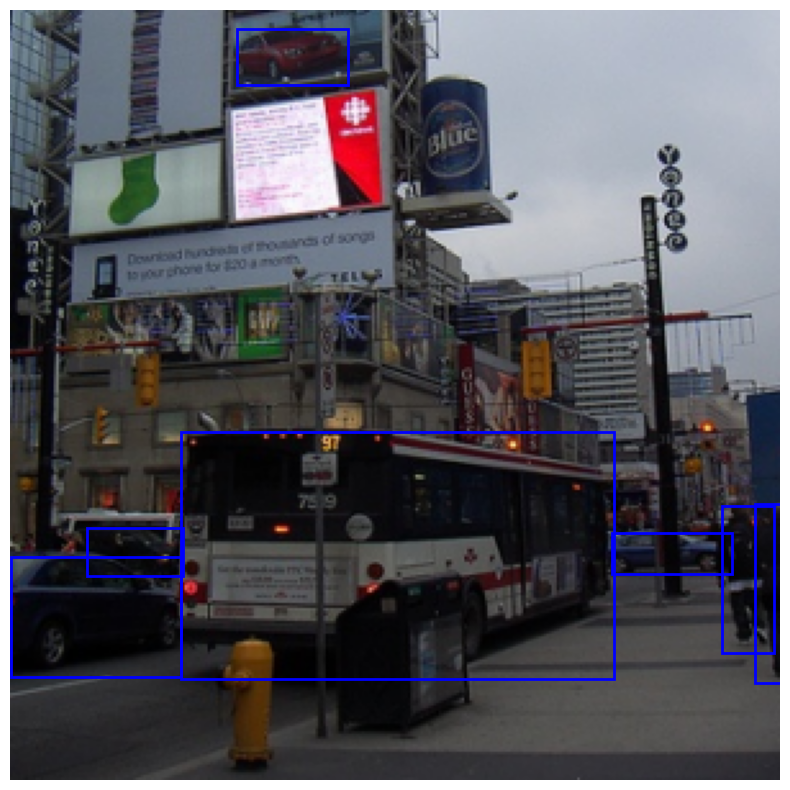

In [1000]:
plot_images(img_t2, [bbox_t2])

In [1001]:
new_labels = torch.zeros(8732, dtype=int)
new_labels

tensor([0, 0, 0,  ..., 0, 0, 0])

In [1002]:
labels_t2

tensor([ 9, 19, 19, 14, 14, 14, 19, 19])

In [1003]:
c1 = torch.max(j, dim=1)
c1

torch.return_types.max(
values=tensor([0.6468, 0.7059, 0.7259, 0.3644, 0.6886, 0.0000, 0.7336, 0.7352]),
indices=tensor([8285, 4969,  727, 5734, 5582,    0, 1017, 1985]))

In [1004]:
c2 = j>0.5

In [1005]:
new_labels[(j>0.5)[0]] = labels_t2[0]

In [1006]:
for i in range(len(c2)):
    new_labels[(j>0.5)[i]] = labels_t2[i]

In [1007]:
not_c1 = (c1[0]==0)
not_c1

tensor([False, False, False, False, False,  True, False, False])

In [1008]:
new_labels[c1[1]]

tensor([ 9, 19, 19,  0, 14,  0, 19, 19])

In [1009]:
i1 = c1[1][~not_c1]
i1

tensor([8285, 4969,  727, 5734, 5582, 1017, 1985])

In [1010]:
labels_t2[~not_c1]

tensor([ 9, 19, 19, 14, 14, 19, 19])

In [1011]:
new_labels[i1] = labels_t2[~not_c1]

In [1012]:
new_labels.unique()

tensor([ 0,  9, 14, 19])

In [1013]:
new_labels = torch.zeros(8732, dtype=int)

In [1014]:
torch.max(j, dim=0)[0]>0.5

tensor([False, False, False,  ..., False, False, False])

In [1015]:
crit2 = torch.max(j, dim=0) # (8732)
crit2_ = crit2[0] >= 0.5 # (8732): Bool mask
new_labels[crit2_] = labels_t2[crit2[1][crit2_]]

In [1016]:
labels_t2[crit2[1][crit2_]]

tensor([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9])

In [1017]:
crit2[1][crit2_]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 6, 6, 6, 7, 7, 7, 7, 7, 7, 1,
        1, 1, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1018]:
j.shape

torch.Size([8, 8732])

In [1019]:
crit2[1][-10:]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1020]:
labels_t2

tensor([ 9, 19, 19, 14, 14, 14, 19, 19])

In [1021]:
max_iou_per_dbox = torch.max(j, dim=0)
crit2 = max_iou_per_dbox[0]>=0.5
crit2_idx = max_iou_per_dbox[1][crit2]

In [1022]:
crit2

tensor([False, False, False,  ..., False, False, False])

In [1023]:
new_labels[crit2_idx]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1024]:
crit1 = torch.max(j, dim=1)
crit1

torch.return_types.max(
values=tensor([0.6468, 0.7059, 0.7259, 0.3644, 0.6886, 0.0000, 0.7336, 0.7352]),
indices=tensor([8285, 4969,  727, 5734, 5582,    0, 1017, 1985]))

In [1025]:
def match_dboxes(labels, overlaps):
    """
    overlaps: (N, 8732), labels: (N)
    Result: labels for all default boxes (8732)
    Criterias: 1. Default box with max overlap
               2. Default boxes with overlap > 0.5
    """
    new_labels = torch.zeros(8732, dtype=int)
    crit1 = torch.max(overlaps, dim=1)
    crit2 = overlaps >= 0.5

    not_crit1 = crit1[0]<=0
    new_labels[crit1[1][~not_crit1]] = labels[~not_crit1]

    for i in range(len(crit2)):
        new_labels[crit2[i]] = labels[i]

    return new_labels


In [1026]:
def match_dboxes(labels, overlaps):
    """
    overlaps: (N, 8732), labels: (N)
    Result: labels for all default boxes (8732)
    Criterias: 1. Default box with max overlap
               2. Default boxes with overlap > 0.5
    """
    new_labels = torch.zeros(8732, dtype=int)

    # Criteria 2: Assign each default box to the highest IoU ground truth if IoU > 0.5
    max_iou_per_dbox = torch.max(overlaps, dim=0)
    crit2 = max_iou_per_dbox[0]>=0.5
    new_labels[crit2] = labels[max_iou_per_dbox[1][crit2]]

    # Criteria 1: Ensure each ground truth is assigned to at least one default box
    max_iou_per_label = torch.max(overlaps, dim=1)
    crit1 = max_iou_per_label[0]>0
    new_labels[max_iou_per_label[1][crit1]] = labels[crit1]

    return new_labels

In [1027]:
new_labels = match_dboxes(labels_t2, j)

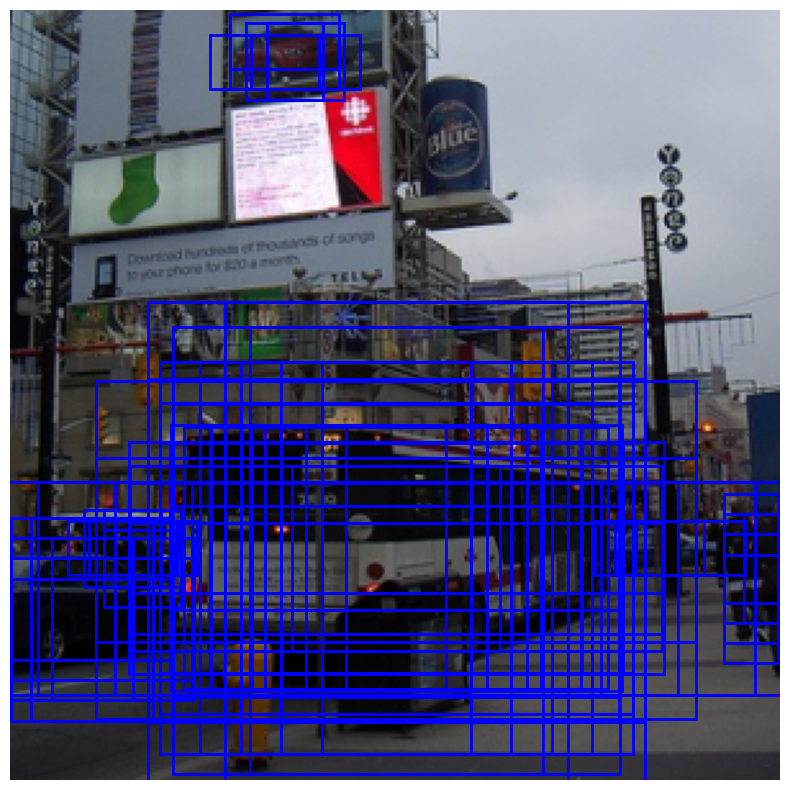

In [1028]:
plot_images(img_t2, [dboxes_xyxy[new_labels>0]*300])

In [1029]:
len([i for i in new_labels if i])

87

In [1030]:
new_labels.unique()

tensor([ 0,  9, 14, 19])

In [1031]:
bbox_t2, labels_t2

(BoundingBoxes([[ 66.0550, 164.0227, 234.8624, 260.0566],
                [233.9449, 203.1161, 280.7339, 219.2635],
                [  0.0000, 212.4646,  66.0550, 259.2068],
                [289.9083, 192.0680, 300.0000, 261.7564],
                [277.0642, 192.9178, 297.2477, 249.8584],
                [300.0000, 198.0170, 300.0000, 241.3598],
                [ 29.3578, 201.4164,  66.9725, 220.1133],
                [ 88.0734,   6.7989, 131.1927,  28.8952]], format=BoundingBoxFormat.XYXY, canvas_size=(300, 300)),
 tensor([ 9, 19, 19, 14, 14, 14, 19, 19]))

In [1032]:
# Problem: I didn't store the corresponding gt bbox, so I can't generate offsets for a class occuring more than once in labels

In [1033]:
def generate_gt():
    pass

#Matching done right

In [1034]:
# Idea: Second column will be enough if used correctly, because labels and bboxes are corresponding

In [1035]:
# Idea is better
new_labels3 = torch.zeros(8732, dtype=int)

In [1036]:
c2 = torch.max(j, dim=0) # (8732)
c2

torch.return_types.max(
values=tensor([0.0000, 0.0000, 0.0000,  ..., 0.1824, 0.2224, 0.2224]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [1037]:
c2[1].unique()

tensor([0, 1, 2, 3, 4, 6, 7])

In [1038]:
[list(c2[1]).count(i) for i in c2[1].unique()]

[6796, 167, 587, 68, 292, 146, 676]

In [1039]:
mask = c2[0]>=0.5 # Bool Mask: (8732)

In [1040]:
# Only pick those indices which have overlap>=0.5 through bool mask
c2[1][c2[0]>=0.5]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 6, 6, 6, 7, 7, 7, 7, 7, 7, 1,
        1, 1, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1041]:
# Only assign indices to labels so it can access both labels and bboxes
new_labels3[mask] = c2[1][mask]

In [1042]:
labels_t2

tensor([ 9, 19, 19, 14, 14, 14, 19, 19])

In [1043]:
labels_t2[new_labels3]

tensor([9, 9, 9,  ..., 9, 9, 9])

In [1044]:
# Problem: As 0th index is an object so all zeros that are considered as bg are treated as objects.

In [1045]:
# Idea failed

In [1046]:
[index_to_labels[i.item()] for i in labels_t2]

['bus', 'car', 'car', 'person', 'person', 'person', 'car', 'car']

In [1047]:
labels_t2[None]

tensor([[ 9, 19, 19, 14, 14, 14, 19, 19]])

In [1048]:
# One row will store labels and other will store corresponding index of corresponding bbox
new_labels2 = torch.zeros(2, 8732, dtype=int)

In [1049]:
c2 = torch.max(j, dim=0)
c2

torch.return_types.max(
values=tensor([0.0000, 0.0000, 0.0000,  ..., 0.1824, 0.2224, 0.2224]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [1050]:
mask = c2[0]>=0.5

In [1051]:
idx2 = c2[1][mask]
idx2

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 6, 6, 6, 7, 7, 7, 7, 7, 7, 1,
        1, 1, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1052]:
# Labels for first row
new_labels2[0][mask] = labels_t2[idx2]

In [1053]:
# Indices for second row
new_labels2[1][mask] = idx2

In [1054]:
c1 = torch.max(j, dim=1)
c1

torch.return_types.max(
values=tensor([0.6468, 0.7059, 0.7259, 0.3644, 0.6886, 0.0000, 0.7336, 0.7352]),
indices=tensor([8285, 4969,  727, 5734, 5582,    0, 1017, 1985]))

In [1055]:
mask2 = c1[0]>0

In [1056]:
c1[1][c1[0]>0]

tensor([8285, 4969,  727, 5734, 5582, 1017, 1985])

In [1057]:
idx1 = torch.range(0, 7, dtype=int)[mask2]

<ipython-input-1057-8d2fec343b17>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  idx1 = torch.range(0, 7, dtype=int)[mask2]


In [1058]:
labels_t2[mask2]

tensor([ 9, 19, 19, 14, 14, 19, 19])

In [1059]:
labels_t2[idx1]

tensor([ 9, 19, 19, 14, 14, 19, 19])

In [1060]:
labels_t2[mask2]

tensor([ 9, 19, 19, 14, 14, 19, 19])

In [1061]:
new_labels2[0, c1[1][mask2]] = labels_t2[idx1]

In [1062]:
new_labels2[1, c1[1][mask2]] = idx1

In [1063]:
torch.arange(8, dtype=int)

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [1064]:
def match_dboxes(labels, overlaps):
    new_labels = torch.zeros((2, 8732), dtype=int)

    # Criteria 2
    max_iou_per_dbox = torch.max(overlaps, dim=0)
    mask2 = max_iou_per_dbox[0]>=0.5
    idx2 = max_iou_per_dbox[1][mask2]
    new_labels[0][mask2] = labels[idx2]
    new_labels[1][mask2] = idx2

    # Criteria 1
    max_iou_per_label = torch.max(overlaps, dim=1)
    mask1 = max_iou_per_label[0]>0
    idx1 = max_iou_per_label[1][mask1]
    new_labels[0, idx1] = labels[mask1]
    new_labels[1, idx1] = torch.arange(len(labels), dtype=int)[mask1]

    return new_labels

In [1065]:
new_labels = match_dboxes(labels_t2, j)

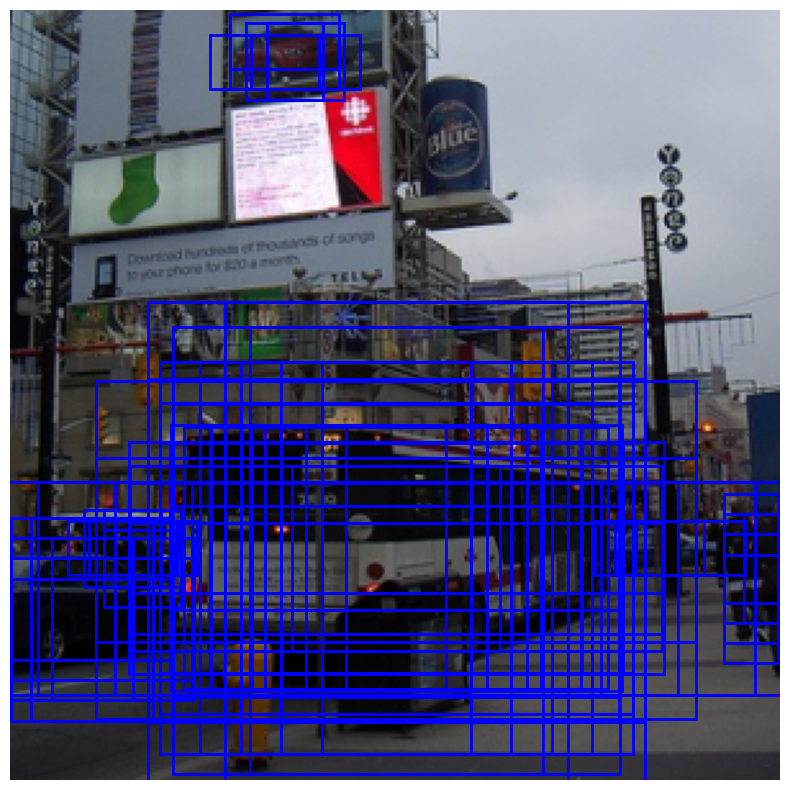

In [1066]:
plot_images(img_t2, [dboxes_xyxy[new_labels[0]>0]*300])

In [1093]:
def match_dboxes(overlaps):
    """
    Takes in overlaps: (N, 8732), Returns tensor: (8732)
    Returned values range from [-1, N), where -1 represents background, and [0, N) corresponds to the index of the matched ground truth label.
    """
    matched_dboxes = torch.ones(8732, dtype=int)*-1

    # Criteria 2
    max_iou_per_dbox = torch.max(overlaps, dim=0)
    mask2 = max_iou_per_dbox[0]>=0.5
    idx2 = max_iou_per_dbox[1][mask2]
    matched_dboxes[mask2] = idx2

    # Criteria 1
    max_iou_per_label = torch.max(overlaps, dim=1)
    mask1 = max_iou_per_label[0]>0
    idx1 = max_iou_per_label[1][mask1]
    matched_dboxes[idx1] = torch.arange(overlaps.shape[0], dtype=int)[mask1]

    return matched_dboxes

In [1116]:
matched_dboxes = match_dboxes(j)

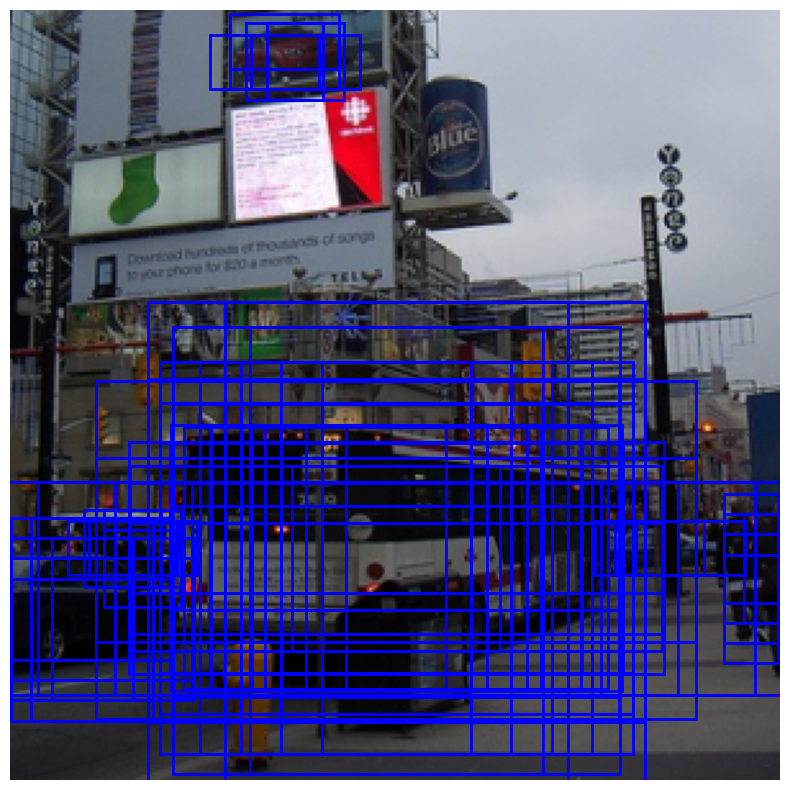

In [1117]:
plot_images(img_t2, [dboxes_xyxy[matched_dboxes!=-1]*300])

#Ground truth generator function

In [1070]:
# Offsets are generated in cwh format so raw ground truth bboxes need to be transformed and normalized first.

In [1085]:
def transform_xyxy_to_cwh(bboxes, img_size=300, norm=False):
    """Expects 2D tensor even if one bbox input."""
    xmin, ymin, xmax, ymax = bboxes.T
    cwh = torch.stack([(xmax+xmin)/2, (ymax+ymin)/2,
                        xmax-xmin, ymax-ymin], dim=1)
    return cwh/(img_size) if norm else cwh

In [1096]:
bbox_cwh = transform_xyxy_to_cwh(bbox_t2, norm=True)
bbox_cwh.shape

torch.Size([8, 4])

In [1086]:
new_labels

tensor([-1, -1, -1,  ..., -1, -1, -1])

In [1087]:
offsets = torch.zeros((8732, 4))
offsets.shape

torch.Size([8732, 4])

In [1088]:
not_bg_mask = new_labels != -1
not_bg_mask

tensor([False, False, False,  ..., False, False, False])

In [1123]:
dboxes_cwh = db_gen.dboxes
dboxes_cwh[not_bg_mask].shape

torch.Size([87, 4])

In [1124]:
bbox_cwh[matched_dboxes[not_bg_mask]].shape

torch.Size([87, 4])

In [1120]:
cx1, cy1, w1, h1 = dboxes_cwh[not_bg_mask].T
cx1.shape

torch.Size([87])

In [1121]:
cx2, cy2, w2, h2 = bbox_cwh[matched_dboxes[not_bg_mask]].T
cx2.shape

torch.Size([87])

In [1132]:
gcx = (cx2-cx1)/w1
gcy = (cy2-cy1)/h1
gw = torch.log(w2/w1)
gh = torch.log(h2/h1)
torch.stack([gcx,gcy,gw,gh]).T.shape
offsets[not_bg_mask] = torch.stack([gcx,gcy,gw,gh]).T

In [1129]:
def generate_offsets(matched_dboxes, bbox_cwh, dboxes_cwh):
    offsets = torch.zeros((8732, 4))
    not_bg_mask = matched_dboxes != -1
    gcx, gcy, gw, gh = bbox_cwh[matched_dboxes[not_bg_mask]].T
    dcx, dcy, dw, dh = dboxes_cwh[not_bg_mask].T
    off_cx = (gcx-dcx)/dw
    off_cy = (gcy-dcy)/dh
    off_w = torch.log(gw/dw)
    off_h = torch.log(gh/dh)
    offsets[not_bg_mask] = torch.stack([off_cx,off_cy,off_w,off_h], dim=1)
    return offsets

In [1138]:
offsets = generate_offsets(matched_dboxes, bbox_cwh, dboxes_cwh)

In [1139]:
def apply_offsets(offsets, dboxes_cwh):
    dcx, dcy, dw, dh = dboxes_cwh.T
    ocx, ocy, ow, oh = offsets.T
    cx = ocx*dw + dcx
    cy = ocy*dh + dcy
    w = torch.exp(ow)*dw
    h = torch.exp(oh)*dh
    return transform_cwh_to_xyxy(torch.stack([cx,cy,w,h], dim=1))

In [1142]:
bb = apply_offsets(offsets, dboxes_cwh)

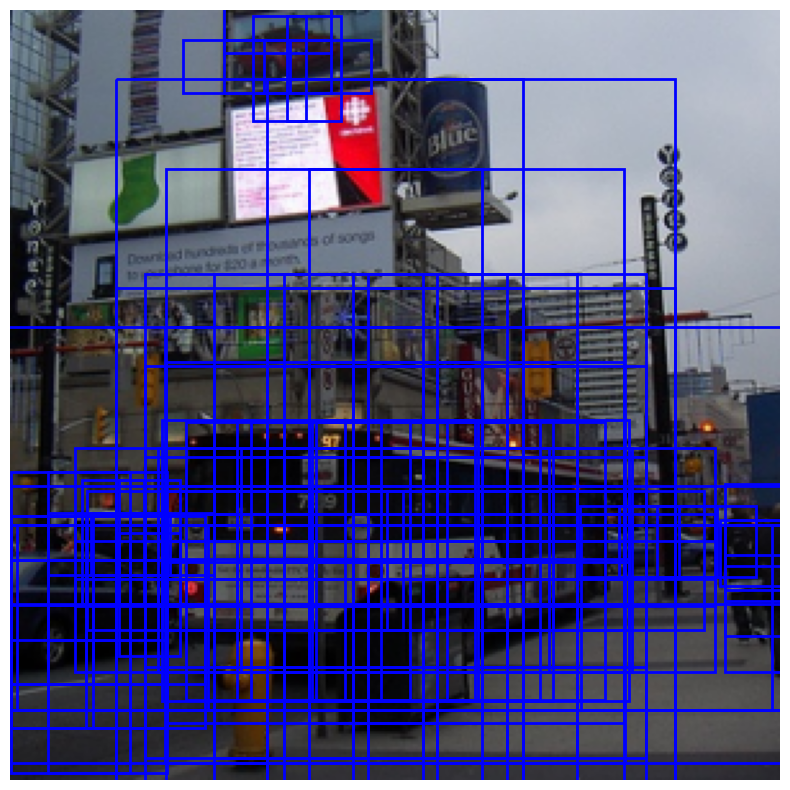

In [1145]:
plot_images(img_t2, [bb[not_bg_mask]*300])

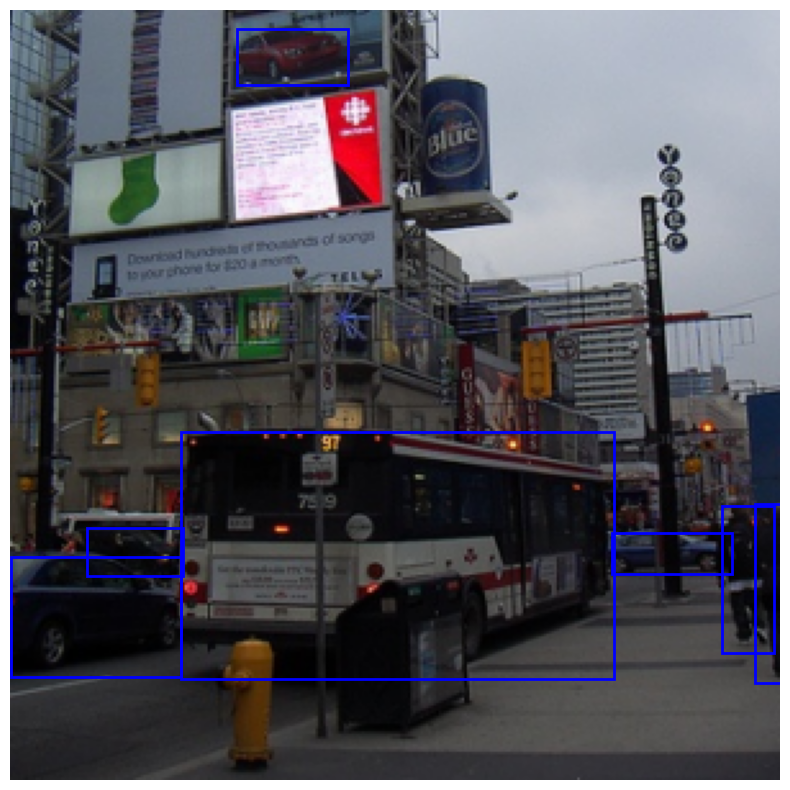

In [1146]:
plot_images(img_t2, [bbox_t2])